In [21]:
import torch
import numpy as np
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


In [22]:
import gdown
import pandas as pd

# -------- Train --------
train_id = "1GKQt7iAbiMfwWMyNXXTkO8WCRA6XdeJgqP9ip1koeQo"
train_file = "train.xlsx"
train_url = f"https://docs.google.com/spreadsheets/d/{train_id}/export?format=xlsx"

gdown.download(train_url, train_file, quiet=False)
train_df = pd.read_excel(train_file)


# -------- Validation --------
val_id = "1JIrWLlWDgKeWjkfHpnlayNAiLinS-TcRmL2oSp4oZsQ"
val_file = "validation.xlsx"
val_url = f"https://docs.google.com/spreadsheets/d/{val_id}/export?format=xlsx"

gdown.download(val_url, val_file, quiet=False)
val_df = pd.read_excel(val_file)


# -------- Test --------
test_id = "1COiSxsK0HKbhLHM-up2UZngZ_neZV7OwZbZJjOw6M4g"
test_file = "test.xlsx"
test_url = f"https://docs.google.com/spreadsheets/d/{test_id}/export?format=xlsx"

gdown.download(test_url, test_file, quiet=False)
test_df = pd.read_excel(test_file)


train_df.head(), val_df.head(), test_df.head()


/usr/local/lib/python3.11/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://docs.google.com/spreadsheets/d/1GKQt7iAbiMfwWMyNXXTkO8WCRA6XdeJgqP9ip1koeQo/export?format=xlsx
To: /kaggle/working/train.xlsx
475kB [00:00, 2.09MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://docs.google.com/spreadsheets/d/1JIrWLlWDgKeWjkfHpnlayNAiLinS-TcRmL2oSp4oZsQ/export?format=xlsx
To: /kaggle/working/validation.xlsx
122kB [00:00, 1.98MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a

(                                                text  label
 0  এই গেরুয়া হিন্দুদের জন্য একজন সাধারণ হিন্দু হি...      0
 1  একটা উপদেশঃ আন্দোলন চালিয়ে যান,,,যতক্ষন না পর্...      0
 2  বাংলাদেশে ধর্মীয় ইস্যুতে কোন হিন্দুর বিচার কী ...      0
 3  স্কুল কলেজ ইউনিভার্সিটি39তে সরস্বতী পূজা হতে প...      0
 4  আমাদের দেশে পুলিশ এত ক্ষমতা পায় কোথায় থেকে এর...      0,
                                                 text  label
 0  চিটার বাটপার বাটপার সব সময় টিভি কালকে সারা দি...      1
 1  যেদিন বাঘের নাম বাদ দিয়ে বন বিড়াল রাখা হবে সেদ...      1
 2          পহেলা বৈশাখের তিন ধাপের নিরাপত্তা কোথায়?      0
 3  ব্যবসাহিক রা আসলে একটু বেশি বাটপার বেশি বাড়াব...      1
 4  ভাগ্যিস মানুষের ঘরে জন্ম নিয়েছি, আওয়ামী লীগের ...      0,
                                                 text  label
 0          যারা মারছে তাদের বিচার হোক ফোটেজ দেখে হোক      0
 1                       ভুট তুদের পিচন দিয়ে দেয়া হবে      2
 2  ষড়যন্ত্রকারীরা কত শক্তিশালী! অঘটন ঘটানোর জন্য...      0
 3  এরকম শিক্ষা প্রথিস

In [23]:
MODEL_NAME = "google-bert/bert-base-multilingual-cased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3 
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# create dataset classes

MAX_LEN = 192  # max token length for Bangla sentences

class ViolenceDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=MAX_LEN):
        self.texts = df['text'].tolist()
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            add_special_tokens=True
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create dataset objects
train_dataset = ViolenceDataset(train_df, tokenizer)
val_dataset = ViolenceDataset(val_df, tokenizer)

In [25]:
# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

class_weights = torch.tensor(class_weights, dtype=torch.float)

In [26]:
# Define compute_metrics function

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
    }

In [27]:
# # Define TrainingArguments

# training_args = TrainingArguments(
#     output_dir="./results",
#     num_train_epochs=3,
#     max_steps=-1,

#     learning_rate=2e-5,
#     weight_decay=0.01,
#     warmup_ratio=0.1,

#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=32,
#     gradient_accumulation_steps=2,

#     eval_strategy="steps",
#     eval_steps=200,

#     logging_strategy="steps",
#     logging_steps=20,
#     logging_first_step=True,

#     save_strategy="steps",
#     save_steps=200,
#     save_total_limit=2,

#     load_best_model_at_end=True,
#     metric_for_best_model="f1_macro",
#     greater_is_better=True,

#     fp16=torch.cuda.is_available(),
#     max_grad_norm=1.0,

#     report_to="none",
#     disable_tqdm=False,
# )

In [28]:
# Define TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",

    # 🔁 updated from Optuna
    num_train_epochs=5,
    max_steps=-1,

    learning_rate=3.342414786252147e-05,
    weight_decay=0.0012009163267654615,
    warmup_ratio=0.13803129538859746,
 
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,

    # num_train_epochs=4,                  # Reduced from 5 to avoid overfit (Optuna used 5, but 3–4 common)
    # learning_rate=3e-5,                  
    # weight_decay=0.01,                   # Standard strong regularization
    # warmup_ratio=0.1,                    # Keep your recent (solid for stability)
    # per_device_train_batch_size=8,       # Smaller for better minority class handling
    # per_device_eval_batch_size=32,
    # gradient_accumulation_steps=2,       # Effective batch ~16 (matches your 78% run)
    
    eval_strategy="steps",
    eval_steps=200,

    logging_strategy="steps",
    logging_steps=20,
    logging_first_step=True,

    save_strategy="steps",
    save_steps=200,
    save_total_limit=2,

    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    fp16=torch.cuda.is_available(),
    max_grad_norm=1.0,

    report_to="none",
    disable_tqdm=False,
)


In [29]:
# Custom loss with class weights

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").long()
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fn = CrossEntropyLoss(
            weight=class_weights.to(logits.device)
        )
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [30]:
# Initialize Trainer

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_47/1537399394.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [31]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
200,0.815800,0.772976,0.668715,0.663939,0.660803,0.668916
400,0.642600,0.737284,0.702793,0.704191,0.713892,0.707330
600,0.418900,0.701617,0.734078,0.733828,0.729261,0.745616
800,0.335900,0.715100,0.759218,0.757128,0.768745,0.750188
1000,0.298400,0.712315,0.769274,0.770312,0.770213,0.772533
1200,0.170100,0.749250,0.782682,0.782676,0.780365,0.786304


TrainOutput(global_step=1310, training_loss=0.5024425255433294, metrics={'train_runtime': 862.0602, 'train_samples_per_second': 48.448, 'train_steps_per_second': 1.52, 'total_flos': 4120849459278720.0, 'train_loss': 0.5024425255433294, 'epoch': 5.0})

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

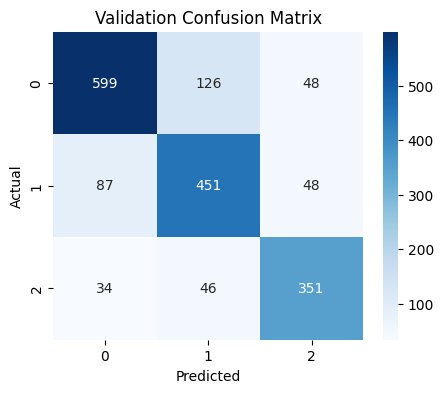

In [33]:
# Get validation predictions
val_predictions = trainer.predict(val_dataset)
val_preds = np.argmax(val_predictions.predictions, axis=1)
val_labels = val_predictions.label_ids

# Compute confusion matrix
cm_val = confusion_matrix(val_labels, val_preds)

# Display
plt.figure(figsize=(5,4))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix')
plt.show()

In [34]:
# convert test data

test_dataset = ViolenceDataset(test_df, tokenizer)

In [35]:
# Get predictions from the trained model

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

In [36]:
# Add a new column for predicted labels
test_df['predicted_label'] = preds

# Save to CSV
test_df.to_csv("bangla_violence_test_predictions.csv", index=False)

# Check first few rows
print(test_df.head())

                                                text  label  predicted_label
0          যারা মারছে তাদের বিচার হোক ফোটেজ দেখে হোক      0                0
1                       ভুট তুদের পিচন দিয়ে দেয়া হবে      2                2
2  ষড়যন্ত্রকারীরা কত শক্তিশালী! অঘটন ঘটানোর জন্য...      0                0
3  এরকম শিক্ষা প্রথিসঠানের নোংরামী কর্ম কান্ডকে ধ...      0                2
4  সারা পৃথিবীর মতপ্রকাশের স্বাধীনতা শুধু ইসলামের...      0                0


In [37]:

from sklearn.metrics import classification_report

predictions = trainer.predict(test_dataset)

y_pred = np.argmax(predictions.predictions, axis=1)

y_true = predictions.label_ids


In [38]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=["class_0", "class_1", "class_2"],
        digits=2
    )
)


              precision    recall  f1-score   support

     class_0       0.83      0.80      0.82       773
     class_1       0.75      0.77      0.76       586
     class_2       0.79      0.80      0.79       431

    accuracy                           0.79      1790
   macro avg       0.79      0.79      0.79      1790
weighted avg       0.79      0.79      0.79      1790



In [39]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.7492496967315674, 'eval_accuracy': 0.78268156424581, 'eval_f1_macro': 0.7826756016046749, 'eval_precision_macro': 0.7803652922262002, 'eval_recall_macro': 0.7863042332037814, 'eval_runtime': 10.6734, 'eval_samples_per_second': 167.707, 'eval_steps_per_second': 5.247, 'epoch': 5.0}


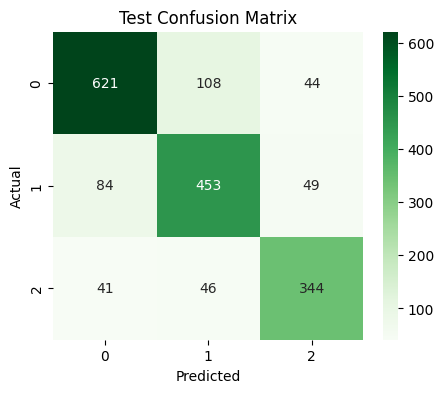

In [40]:
# Confusion Matrix

if 'label' in test_df.columns:
    test_labels = test_df['label'].values
    cm_test = confusion_matrix(test_labels, preds)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test Confusion Matrix')
    plt.show()
else:
    print("No true labels in test set; cannot compute confusion matrix for test data.")